In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from mapsgan import BaseSolver, experiments, data_loader, BicycleSolver, cos_scene
from mapsgan import ToyGenerator, ToyDiscriminator, BicycleGenerator, norm_scene, cos_scene, get_z_random
from mapsgan.evaluation import Visualization
from sgan import TrajectoryDiscriminator, TrajectoryGenerator
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import os
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# list all models
model_path = '../../sgan/sgan/models/sgan-p-models/'
os.listdir(model_path)

['eth_12_model.pt',
 'eth_8_model.pt',
 'hotel_12_model.pt',
 'hotel_8_model.pt',
 'univ_12_model.pt',
 'univ_8_model.pt',
 'zara1_12_model.pt',
 'zara1_8_model.pt',
 'zara2_12_model.pt',
 'zara2_8_model.pt']

In [7]:
def get_generator(checkpoint, cuda=False):
    from attrdict import AttrDict
    args = AttrDict(checkpoint['args'])
    generator = TrajectoryGenerator(
        obs_len=args.obs_len,
        pred_len=args.pred_len,
        embedding_dim=args.embedding_dim,
        encoder_h_dim=args.encoder_h_dim_g,
        decoder_h_dim=args.decoder_h_dim_g,
        mlp_dim=args.mlp_dim,
        num_layers=args.num_layers,
        noise_dim=args.noise_dim,
        noise_type=args.noise_type,
        noise_mix_type=args.noise_mix_type,
        pooling_type=args.pooling_type,
        pool_every_timestep=args.pool_every_timestep,
        dropout=args.dropout,
        bottleneck_dim=args.bottleneck_dim,
        neighborhood_size=args.neighborhood_size,
        grid_size=args.grid_size,
        batch_norm=args.batch_norm)
    generator.load_state_dict(checkpoint['g_state'])
    if cuda:
        generator.cuda()
    generator.train()
    return generator
ml = 'cpu' if not cuda else None
checkpoint = torch.load(model_path + 'eth_12_model.pt', map_location=ml)


In [8]:
experiment = experiments.ETH() 
dataset, trainloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=False)

dataset, testloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=1,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=False)

# Note, the discriminator has not been pretrained
discriminator = TrajectoryDiscriminator(obs_len=8,
                                        pred_len=12,
                                        embedding_dim=16,
                                        h_dim=64,
                                        mlp_dim=64,
                                        num_layers=1,
                                        dropout=0,
                                        batch_norm=0,
                                        d_type='local')


In [9]:
mode = 'cvae'
fileprefix = '/cloud/sgan_bicy_1'
lr_gen = 1e-3
lr_dis = 1e-3
loss_weights={'disc': 1, 'traj': 2, 'kl': 0.1, 'z': 1}
obs_len=8,
pred_len=12
embedding_dim=16
encoder_h_dim=32
decoder_h_dim=32
mlp_dim=64
num_layers=1
noise_dim=(8,)
noise_type='gaussian'
noise_mix_type='global'
pooling_type='pool_net'

generator = get_generator(checkpoint)
generator = BicycleGenerator(generator=generator, start_mode=mode,
                    embedding_dim=embedding_dim, h_dim=decoder_h_dim-8, z_dim=8,
                    in_len=obs_len, out_len=pred_len, noise_type=noise_type, noise_mix_type=noise_mix_type )

solver = BicycleSolver(generator, discriminator,
                    loss_weights=loss_weights,
                    optims_args={'generator': {'lr': 1e-3},
                                'discriminator': {'lr': 1e-3},
                                'encoder': {'lr': 1e-3}}, two_discr =True)
solver.validate_acc=False

In [19]:
solver.optimizer_d.copy()

AttributeError: 'Adam' object has no attribute 'copy'

In [10]:
solver.train(trainloader, epochs = 10000, checkpoint_every=1, print_every=1, val_every=5, testloader=testloader, steps={'generator': 1, 'discriminator': 1},
              save_model=True, model_name=fileprefix, save_every=499, restore_checkpoint_from=None)


       Generator Losses                        Discriminator Losses
Epochs G_BCE     G_L1      G_L1z     G_KL      D_Real    D_Fake    
10000  0.693     0.154               53.723    0.692     0.697     
9999   0.693     0.154     0.817     53.723    0.691     0.696     
9998   0.693     0.223     0.817     44.560    0.693     0.693     
9997   0.689     0.223     0.814     44.560    0.693     0.693     
9996   0.693     0.148     0.814     39.117    0.693     0.693     
9995   0.692     0.148     0.799     39.117    0.691     0.698     
9994   0.693     0.153     0.799     34.846    0.693     0.693     
9993   0.693     0.153     0.857     34.846    0.692     0.695     
9992   0.693     0.144     0.857     31.355    0.693     0.693     
9991   0.693     0.144     0.829     31.355    0.693     0.693     
9990   0.693     0.146     0.829     28.423    0.693     0.693     
9989   0.693     0.146     0.812     28.423    0.693     0.693     
9988   0.693     0.130     0.812     25.921    

Process Process-135:
Traceback (most recent call last):
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/j.lappalainen/anaconda3/envs/mapsgan/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/j.lappa

RuntimeError: DataLoader worker (pid 16443) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [16]:
l1 = nn.L1Loss()
l1(solver.generator.z_random, get_z_random(169, 8))

tensor(1.1457)

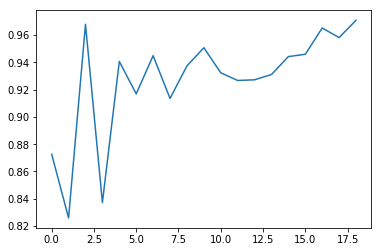

In [13]:
plt.plot(solver.train_loss_history['validation']['diversity']['scene_cos'])
#plt.plot(solver.train_loss_history['validation']['diversity']['agent_interp'])
#plt.plot(solver.train_loss_history['validation']['collisions'])

In [35]:
def get_collisions(output, thresh=0.5):
    """Computes collision on array of (seq_len, num_agents, num_chords)"""
    from scipy.spatial.distance import pdist, squareform
    collisions = 0
    xy_pred = output['xy_pred']
    for scene in xy_pred:
        for i, step_na_xy in enumerate(scene):
            dm = squareform(pdist(step_na_xy))  # step is (num_agents, dimensions xy) 
            ind = np.triu_indices(dm.shape[0], k=1)
            for distance in dm[ind]:
                if distance < thresh:
                    collisions += 1
    return collisions

def get_average_fde(output):
    pred = output['xy_pred']
    gt = output['xy_out']
    diff = 0
    for i, scene in enumerate(pred):
        last_p = scene[-1]
        last_gt = gt[i][-1]
        diff += np.linalg.norm((last_p-last_gt), axis=1).mean()
    diff /= len(pred)
    return diff
    

In [36]:
output = solver.test(trainloader)

In [37]:
get_collisions(output), get_average_fde(output), cos_scene(output['xy_pred'])/cos_scene(output['xy_out'])
#(71, 0.695486674032041) after a few epochs of bicycle on test

(61, 0.9775708045278276, 0.9492819032576324)